In [46]:
import cv2
import numpy as np

from tensorflow.lite.python.interpreter import Interpreter
# from tensorflow.lite.python.interpreter 


# ===== Load model TFLite =====
interpreter = Interpreter(model_path="facenet_int_quantized.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input:", input_details[0])
print("Output:", output_details)


# ===== Tiền xử lý ảnh =====
def preprocess_face(img_path, target_size=(160,160)):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    # img = img.astype(np.float32) / 255.0  # scale [0,1]
    img = (img.astype(np.float32) - 127.5) / 128.0
    img = np.expand_dims(img, axis=0)     # (1,160,160,3)
    return img


# ===== Extract embedding =====
def get_embedding(img_path):
    img = preprocess_face(img_path)
    
    # đảm bảo dtype khớp với model
    if img.dtype != input_details[0]['dtype']:
        img = img.astype(input_details[0]['dtype'])

    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    embeds = interpreter.get_tensor(output_details[0]['index'])  # (128,)

    # L2 normalize
    norms = np.linalg.norm(embeds, axis=1, keepdims=True)
    embeds = embeds / norms
    
    return embeds


# ===== Demo =====
if __name__ == "__main__":
    emb1 = get_embedding(r'./make.png')[0]
    emb2 = get_embedding(r"./images/moc.png")[0]

    # cosine similarity
    cos_sim = np.dot(emb1, emb2)
    print("Cosine similarity:", cos_sim)


Input: {'name': 'input_2', 'index': 0, 'shape': array([  1, 160, 160,   3], dtype=int32), 'shape_signature': array([ -1, 160, 160,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Output: [{'name': 'Identity', 'index': 450, 'shape': array([  1, 128], dtype=int32), 'shape_signature': array([ -1, 128], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Cosine similarity: 0.78878206


In [42]:
import cv2
import numpy as np
import tensorflow as tf

# ===== Load model Keras (.h5) =====
MODEL_PATH = "./models/model recognite/Facenet_128.h5"
model = tf.keras.models.load_model(MODEL_PATH, safe_mode=False)

print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)


# ===== Tiền xử lý ảnh =====
def preprocess_face(img_path, target_size=(160, 160)):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)

    # Chuẩn hoá [-1,1] (chuẩn Facenet)
    img = (img.astype(np.float32) - 127.5) / 128.0
    # mean, std = img.mean(), img.std()
    # img = (img - mean) / std
    img = np.expand_dims(img, axis=0)  # (1,160,160,3)
    return img


# ===== Extract embedding =====
def get_embedding(img_path):
    img = preprocess_face(img_path)
    emb = model.predict(img, verbose= False)[0]   # (128,)
    emb = emb / np.linalg.norm(emb)  # L2 normalize
    return emb


# ===== Demo =====
if __name__ == "__main__":
    emb1 = get_embedding("./make.png")
    emb2 = get_embedding(r"./images/moc.png")

    # Cosine similarity
    cos_sim = np.dot(emb1, emb2)
    print("Cosine similarity:", cos_sim)


Model input shape: (None, 160, 160, 3)
Model output shape: (None, 128)
Cosine similarity: 0.787315


In [1]:
from deepface import DeepFace

In [17]:
# result = DeepFace.verify(img1_path = "db/vanh1.png", img2_path = "db/Screenshot 2025-09-03 164156.png")
dfs = DeepFace.find(img_path = "db/vanh1.png", db_path = r"db", model_name= 'Facenet')

25-09-07 16:59:20 - Searching db/vanh1.png in 17 length datastore


ValueError: Length of values (16) does not match length of index (17)

In [4]:
from deepface.models.facial_recognition.Facenet import load_facenet128d_model
model = load_facenet128d_model()

In [26]:
model.save('Facenet_128.h5')

In [29]:
from keras.models import load_model

model = load_model('Facenet_128.h5', safe_mode= False)

In [ ]:
from keras.models import Model, Sequential
from keras.layers import (
    Convolution2D,
    ZeroPadding2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    Activation,
)
def base_model() -> Sequential:
    """
    Base model of VGG-Face being used for classification - not to find embeddings
    Returns:
        model (Sequential): model was trained to classify 2622 identities
    """
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Convolution2D(4096, (7, 7), activation="relu"))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation="relu"))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation("softmax"))

    return model

In [18]:
model = base_model()

In [ ]:
model.load_weights('vgg_face_weights.h5')

In [ ]:
import math
import numpy as np
from numpy.linalg import norm

# Config DeepFace cho Facenet + cosine
FACENET_CONF = {
    "w": -6.502269165856082,
    "b": 1.679048923097668,
    "normalizer": 1.206694,
    "denorm_max_true": 77.17253153662926,
    "denorm_min_true": 41.790002608273234,
    "denorm_max_false": 20.618350202170916,
    "denorm_min_false": 0.7976712344840693,
}

# Threshold DeepFace thường dùng cho Facenet + cosine
FACENET_COSINE_THRESHOLD = 0.40  

def cosine_distance(embed1, embed2) -> float:
    """Tính cosine distance = 1 - cosine similarity."""
    cos_sim = np.dot(embed1, embed2) / (norm(embed1) * norm(embed2))
    return 1 - cos_sim

def find_confidence(distance: float, verified: bool, config: dict = FACENET_CONF) -> float:
    """DeepFace-style confidence scaling."""
    w = config["w"]
    b = config["b"]
    normalizer = config["normalizer"]

    denorm_max_true = config["denorm_max_true"]
    denorm_min_true = config["denorm_min_true"]
    denorm_max_false = config["denorm_max_false"]
    denorm_min_false = config["denorm_min_false"]

    # normalize distance
    if normalizer > 1:
        distance = distance / normalizer

    # logistic
    z = w * distance + b
    confidence = 100 * (1 / (1 + math.exp(-z)))

    # re-distribute
    if verified:
        min_original, max_original = denorm_min_true, denorm_max_true
        min_target, max_target = max(51, min_original), 100
    else:
        min_original, max_original = denorm_min_false, denorm_max_false
        min_target, max_target = 0, min(49, max_original)

    confidence_distributed = ((confidence - min_original) / (max_original - min_original)) * (
        max_target - min_target
    ) + min_target

    # ensure range
    if verified and confidence_distributed < 51:
        confidence_distributed = 51
    elif not verified and confidence_distributed > 49:
        confidence_distributed = 49

    confidence_distributed = min(100, max(0, confidence_distributed))
    return round(confidence_distributed, 2)

def verify_face(embed1, embed2):
    """So khớp 2 embedding theo Facenet + cosine (DeepFace style)."""
    distance = cosine_distance(embed1, embed2)
    verified = distance <= FACENET_COSINE_THRESHOLD
    confidence = find_confidence(distance, verified, FACENET_CONF)
    return {
        "distance": round(distance, 4),
        "verified": verified,
        "confidence": confidence,
    }

# ==============================
# 1. Config DeepFace cho Facenet + cosine
# ==============================
FACENET_CONF = {
    "w": -6.502269165856082,
    "b": 1.679048923097668,
    "normalizer": 1.206694,
    "denorm_max_true": 77.17253153662926,
    "denorm_min_true": 41.790002608273234,
    "denorm_max_false": 20.618350202170916,
    "denorm_min_false": 0.7976712344840693,
}
FACENET_COSINE_THRESHOLD = 0.40  # ngưỡng DeepFace dùng cho Facenet + cosine

def find_confidence(distance: float, verified: bool, config: dict = FACENET_CONF) -> float:
    """DeepFace-style confidence scaling."""
    w = config["w"]
    b = config["b"]
    normalizer = config["normalizer"]

    denorm_max_true = config["denorm_max_true"]
    denorm_min_true = config["denorm_min_true"]
    denorm_max_false = config["denorm_max_false"]
    denorm_min_false = config["denorm_min_false"]

    # normalize distance
    if normalizer > 1:
        distance = distance / normalizer

    # logistic
    z = w * distance + b
    confidence = 100 * (1 / (1 + math.exp(-z)))

    # re-distribute
    if verified:
        min_original, max_original = denorm_min_true, denorm_max_true
        min_target, max_target = max(51, min_original), 100
    else:
        min_original, max_original = denorm_min_false, denorm_max_false
        min_target, max_target = 0, min(49, max_original)

    confidence_distributed = ((confidence - min_original) / (max_original - min_original)) * (
        max_target - min_target
    ) + min_target

    # ensure range
    if verified and confidence_distributed < 51:
        confidence_distributed = 51
    elif not verified and confidence_distributed > 49:
        confidence_distributed = 49

    confidence_distributed = min(100, max(0, confidence_distributed))
    return round(confidence_distributed, 2)

# ==============================
# 2. Hàm so khớp (cosine distance + logistic confidence)
# ==============================
def cosine_distance(embed1, embed2) -> float:
    """Tính cosine distance = 1 - cosine similarity."""
    cos_sim = np.dot(embed1, embed2) / (norm(embed1) * norm(embed2))
    return 1 - cos_sim


def verify_face(embed1, embed2):
    """So khớp 2 embedding theo Facenet + cosine (DeepFace style)."""
    distance = cosine_distance(embed1, embed2)
    verified = distance <= FACENET_COSINE_THRESHOLD
    confidence = find_confidence(distance, verified, FACENET_CONF)
    return {
        "distance": round(distance, 4),
        "verified": verified,
        "confidence": confidence,
    }


In [69]:
import numpy as np
import faiss

# Tạo dữ liệu giả lập
d = 512  # chiều của vector
nb = 1000  # số lượng vector trong tập dữ liệu
nq = 1  # số lượng vector truy vấn
np.random.seed(123)
xb = np.random.random((nb, d)).astype('float32')  # tập dữ liệu
xq = np.random.random((nq, d)).astype('float32')  # truy vấn

# Tạo index với Exact Search (L2 distance)
index =faiss.IndexFlatIP(d)
index.add(xb)  # Thêm dữ liệu vào index

In [1]:
xb[0].shape

NameError: name 'xb' is not defined

In [55]:
index.remove_ids(np.array([1, 2, 5], dtype= np.int64))

0

In [67]:
a = np.array([1, 2, 2, 2, 5], dtype= np.int64)
np.where(a == 2)[0][0]

np.int64(1)

In [56]:
# index.
# Tìm kiếm 5 neighbor gần nhất
k = 1
distances, indices = index.search(xq, k)

print("Khoảng cách:", distances)
print("Chỉ số:", indices)

Khoảng cách: [[139.57271]]
Chỉ số: [[363]]


In [25]:
import numpy as np
index.remove_ids(np.array([2, 3], dtype=np.int64))
index.ntotal

999968

In [8]:
from deepface import DeepFace

result = DeepFace.verify(
    img1_path = path1,
    img2_path = path2,
    model_name = 'Facenet',
    detector_backend= 'mtcnn'
)

print(result)

{'verified': True, 'distance': 0.152357, 'threshold': 0.4, 'confidence': 90.38, 'model': 'Facenet', 'detector_backend': 'mtcnn', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 231, 'y': 191, 'w': 427, 'h': 590, 'left_eye': (np.int64(553), np.int64(432)), 'right_eye': (np.int64(349), np.int64(426))}, 'img2': {'x': 546, 'y': 175, 'w': 271, 'h': 361, 'left_eye': (np.int64(762), np.int64(320)), 'right_eye': (np.int64(636), np.int64(321))}}, 'time': 2.34}


In [1]:
import matplotlib.pyplot as plt
from regcognizer import Regconizer

reg = Regconizer()

from utils import *
def compare(path1: str, path2: str) -> dict:
    img1 = read_image(path1)
    img2 = read_image(path2)
    
    embed1 = reg.get_embedding(img1)[0]
    embed2 = reg.get_embedding(img2)[0]
    return verify_face(embed1, embed2)



In [ ]:
img1 = read_image(path1)
reg.get_embedding(img1)

array([-0.0271937 , -0.30768967,  0.00132408,  0.13989   ,  0.01676076,
       -0.10943751,  0.08084121, -0.05020805, -0.16060886,  0.00850917,
        0.04088294, -0.13294683,  0.00474923, -0.01996388,  0.05300768,
        0.15500377,  0.04465401, -0.05538085,  0.01133279,  0.13983044,
        0.00262138, -0.1085253 , -0.03342212, -0.02222671,  0.02305641,
        0.05587592,  0.08786541,  0.01758787, -0.03510389,  0.13086161,
        0.03589837,  0.06969895, -0.12852912, -0.03747345,  0.01651031,
        0.04396999, -0.13269097, -0.06741183,  0.08221548,  0.08038668,
        0.06424771,  0.03202234,  0.03463683,  0.11969332,  0.12162823,
        0.00430243,  0.00480654,  0.085641  , -0.06719812, -0.00444829,
       -0.01824194,  0.05871248,  0.01464723,  0.03650988,  0.05547317,
       -0.10171214,  0.09573691,  0.09584495,  0.01688048,  0.21486647,
        0.1122779 ,  0.04679808,  0.04961019, -0.02458593, -0.01703039,
       -0.07651509,  0.07635486, -0.02755396, -0.06038718,  0.04

: 

: 

In [1]:
from regcognizer import Regconizer
reg = Regconizer()
from utils import *


Đang load vector db
Đã load xong vector bd


In [15]:
path1 = r'make.png'
path2 = r'G:\Face Regcognite\WIN_20250908_16_51_40_Pro.jpg'
path = 'test.png'

In [20]:
img1 = read_image(path1)
img2 = read_image(path2)
img = read_image(path)



In [2]:
compare(path1, path2)

NameError: name 'compare' is not defined

In [3]:
from vector_db import VectorBD
vt = VectorBD()

Đang load vector db
Đã load xong vector bd
Không tìm thấy vector db, chuẩn bị tạo mới
Đã tạo xong vector bb
Đã tạo lại db mới
Đã thêm thành công moc vào db
Đã thêm thành công my1 vào db
Đã thêm thành công my2 vào db
Đã thêm thành công my3 vào db
Đã thêm thành công my4 vào db
Đã thêm thành công thinh vào db
Đã thêm thành công vanh1 vào db
Đã thêm thành công vanh2 vào db
Đã thêm thành công vanh3 vào db
Đã thêm thành công vanh4 vào db
Đã lưu xong tất cả embedding trong folder
Đang load vector db
Đã load xong vector bd


In [13]:
img1 = read_image(path1)
embed1 = reg.get_embedding(img1)
img2 = read_image(path2)
embed2 = reg.get_embedding(img2)

In [ ]:
a, b = vt.search_emb(embed1)

In [23]:
a[0][0]

np.float32(0.7178253)

In [4]:
# vt.remove_emb('Vanh1')
# vt.update_emb(np.random.random((1, 128)).astype('float32'), 'Vanh')
vt.list_names
vt.index.reconstruct(1).shape

(128,)

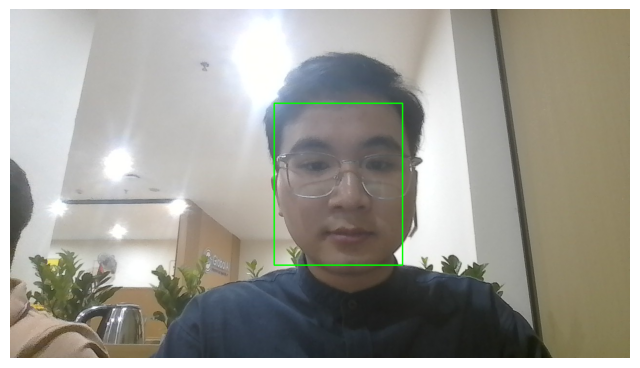

In [18]:
import matplotlib.pyplot as plt
def detect_and_show(image_path):
    # Load ảnh
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    reg.get_faces_img(img_rgb)    
    # print(reg.get_embedding(img_rgb))
    # Hiển thị ảnh
    plt.figure(figsize=(8, 6))
    plt.imshow(reg.img_with_bb)
    plt.axis("off")
    plt.show()

# ==============================
# Example
# ==============================
if __name__ == "__main__":
    detect_and_show(path2)
